In [16]:
# Standard libraries
import sys
# Add your custom path
gems_tco_path = "/Users/joonwonlee/Documents/GEMS_TCO-1/src"
sys.path.append(gems_tco_path)
import os
import logging
import argparse # Argument parsing

# Data manipulation and analysis
import pandas as pd
import numpy as np
import pickle
import torch
import torch.optim as optim
import copy                    # clone tensor
import time

# Custom imports


from GEMS_TCO import kernels_reparam_space_time_gpu as kernels_reparam_space_time
from GEMS_TCO import orderings as _orderings 
from GEMS_TCO import alg_optimization, BaseLogger

from typing import Optional, List, Tuple
from pathlib import Path
import typer
import json
from json import JSONEncoder
from GEMS_TCO import configuration as config
from GEMS_TCO.data_loader import load_data2, exact_location_filter
from GEMS_TCO import debiased_whittle
from torch.nn import Parameter

In [17]:
space: List[str] = ['1', '1']
lat_lon_resolution = [int(s) for s in space]
mm_cond_number: int = 8
years = ['2024']
month_range = [7] 

output_path = input_path = Path(config.mac_estimates_day_path)
data_load_instance = load_data2(config.mac_data_load_path)

#lat_range_input = [1, 3]
#lon_range_input = [125.0, 129.0]

lat_range_input=[-3,2]      
lon_range_input=[121, 131] 
#lat_range_input=[-3,-1]      
#lon_range_input=[121, 125] 

df_map, ord_mm, nns_map, day_offsets = data_load_instance.load_maxmin_ordered_data_bymonthyear(
lat_lon_resolution=lat_lon_resolution, 
mm_cond_number=mm_cond_number,
years_=years, 
months_=month_range,

lat_range=lat_range_input,   
lon_range=lon_range_input
  
)

--- Global Monthly Mean for 2024-7: 258.0436 ---


In [18]:
daily_aggregated_tensors_dw = [] 
daily_hourly_maps_dw = []      

daily_aggregated_tensors_vecc = [] 
daily_hourly_maps_vecc = []   

for day_index in range(31):
    hour_start_index = day_index * 8
    hour_end_index = (day_index + 1) * 8
    hour_indices = [hour_start_index, hour_end_index]

    # --- DW용 데이터 로드 (day_offsets 인자 추가) ---
    day_hourly_map, day_aggregated_tensor = data_load_instance.load_working_data(
        df_map, 
        day_offsets,  # <--- 이 부분이 추가되어야 합니다
        hour_indices, 
        ord_mm=None,
        dtype=torch.float64, 
        keep_ori=True
    )
    daily_aggregated_tensors_dw.append(day_aggregated_tensor)
    daily_hourly_maps_dw.append(day_hourly_map)



🚀 Starting Independent Analysis for Years: ['2022', '2023', '2024', '2025']

--- Processing Year: 2022 ---
--- Global Monthly Mean for 2022-7: 250.7099 ---
--- Processing Year: 2023 ---
--- Global Monthly Mean for 2023-7: 249.8149 ---
--- Processing Year: 2024 ---
--- Global Monthly Mean for 2024-7: 258.0436 ---
--- Processing Year: 2025 ---
--- Global Monthly Mean for 2025-7: 241.5922 ---


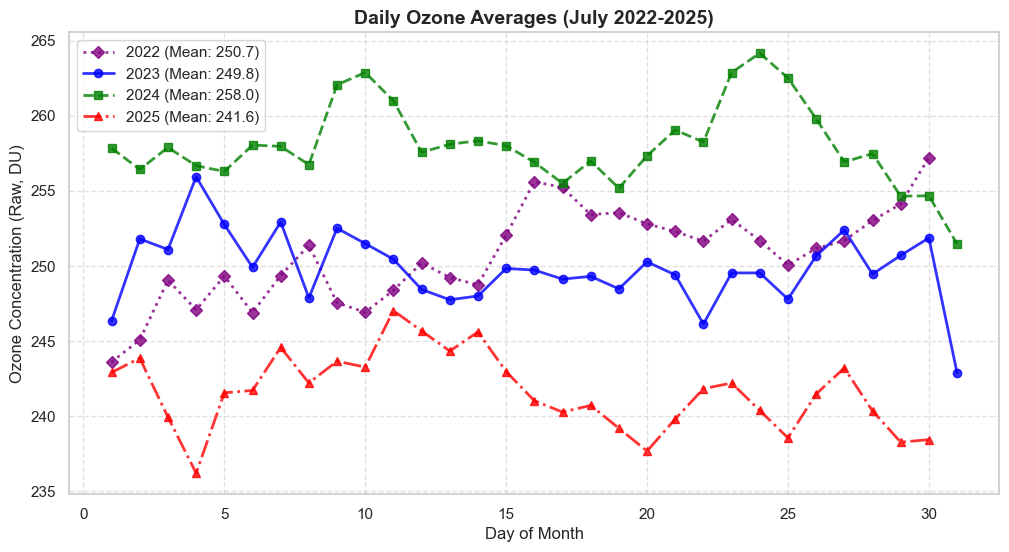

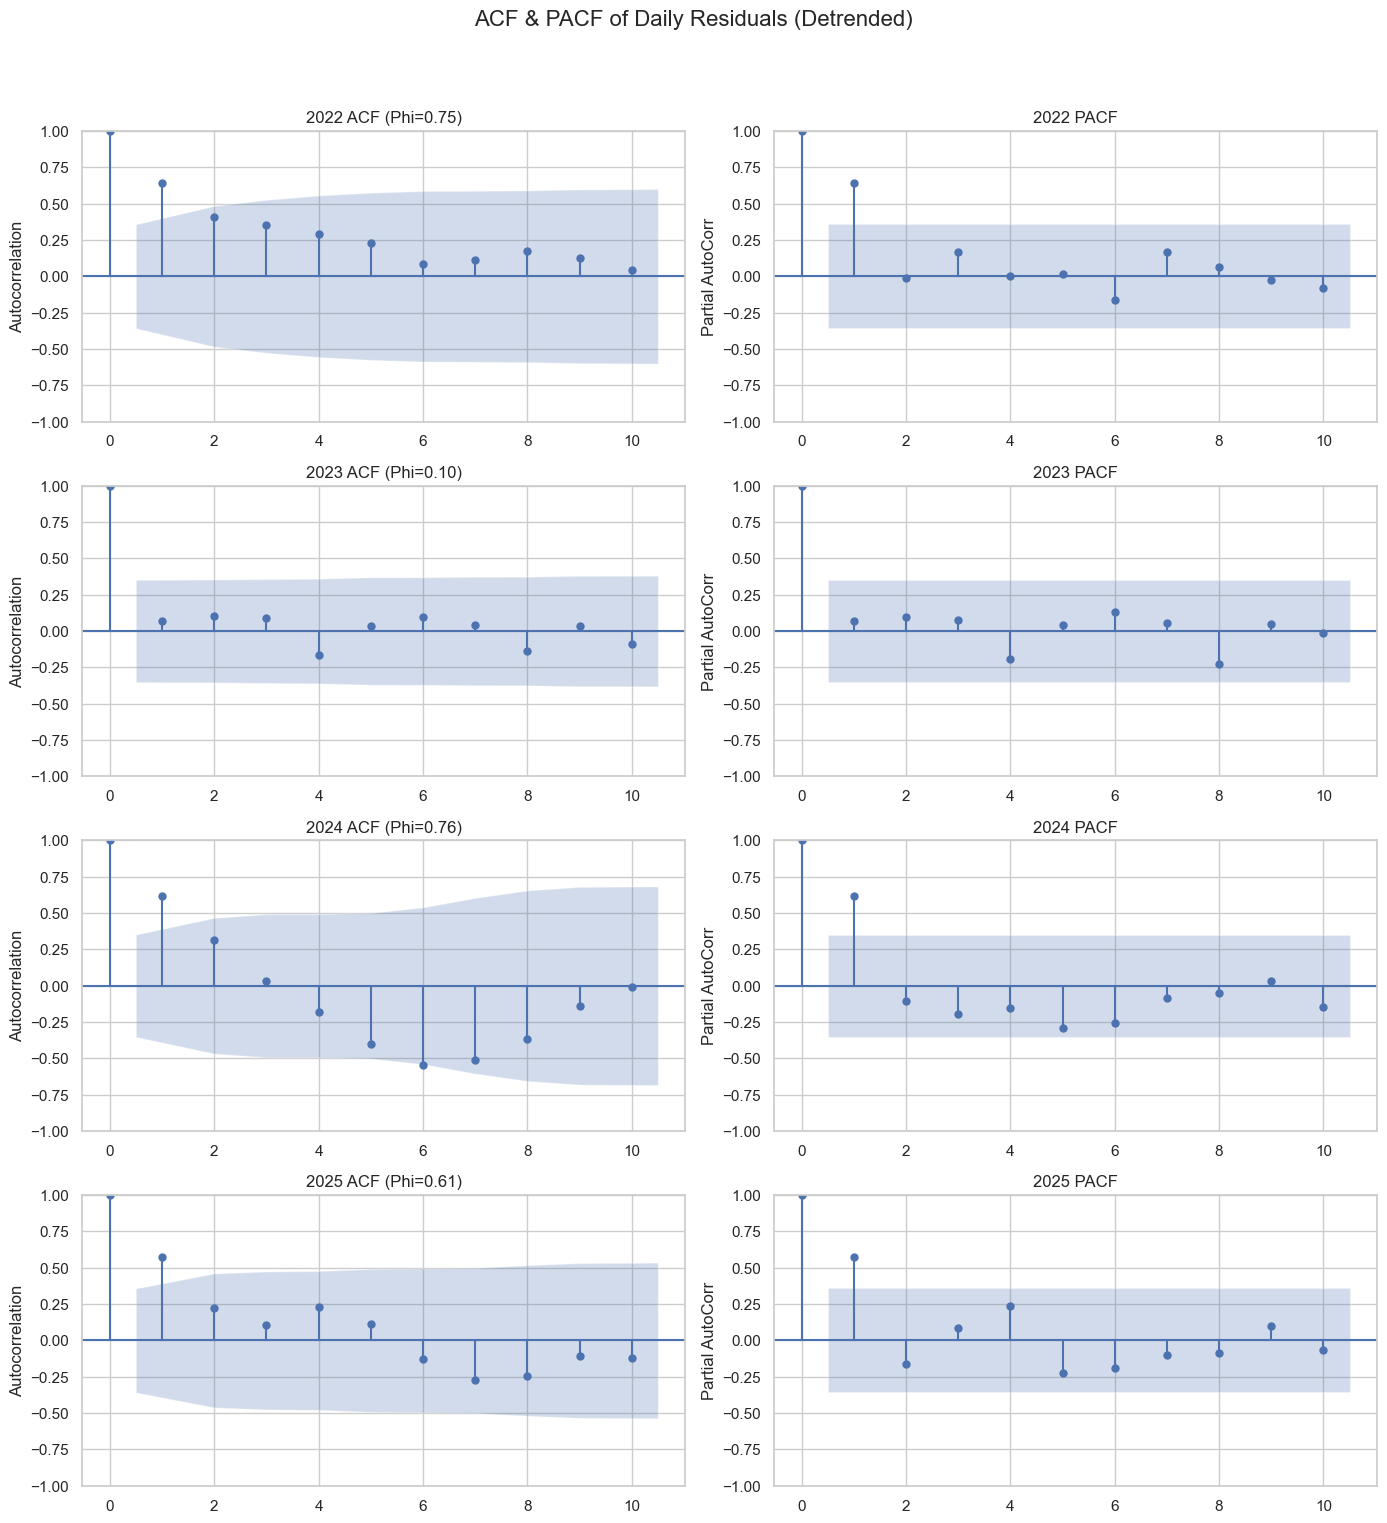


 Year  |  Monthly Mean  |  Daily Var   | AR(1) Phi  | Noise Var 
(Raw)  | (Should be ~260) |  (Mean Var)  | (Persistence) | (Sigma^2) 
---------------------------------------------------------------------------
 2022  |    250.7099    |    9.6590    |   0.7537   |   3.4021  
 2023  |    249.8149    |    5.7514    |   0.0951   |   5.5046  
 2024  |    258.0436    |    7.3532    |   0.7598   |   4.0436  
 2025  |    241.6268    |    6.3355    |   0.6070   |   4.2120  



In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
from collections import defaultdict

# 스타일 설정
sns.set_theme(style="whitegrid")
plt.rcParams.update({'font.size': 11})

# --- 설정 ---
years_list = ['2022', '2023', '2024', '2025']  # 2022년 추가됨
month_range = [7]  # 7월
lat_lon_resolution = [1, 1]
mm_cond_number = 8
lat_range_input = [-3, 2]
lon_range_input = [121, 131]

# 결과 저장용
results = {}

print(f"🚀 Starting Independent Analysis for Years: {years_list}\n")

for year in years_list:
    print(f"--- Processing Year: {year} ---")
    
    # 1. 독립적으로 데이터 로드 (Raw Data)
    # df_map의 2번 컬럼은 실제 오존 농도(Raw Value)입니다.
    try:
        df_map, ord_mm, nns_map, day_offsets = data_load_instance.load_maxmin_ordered_data_bymonthyear(
            lat_lon_resolution=lat_lon_resolution, 
            mm_cond_number=mm_cond_number,
            years_=[year],   
            months_=month_range,
            lat_range=lat_range_input,   
            lon_range=lon_range_input
        )
    except Exception as e:
        print(f"  Error loading data for {year}: {e}")
        results[year] = {'monthly_mean': np.nan, 'residuals': []}
        continue
    
    # 2. 일별 평균 계산 (Raw Data 집계)
    daily_means_list = []
    
    # 키 정렬 (날짜순 가정)
    sorted_keys = sorted(list(df_map.keys()))
    
    # GEMS 데이터 구조 가정 (하루 8장)
    hours_per_day = 8
    num_days = len(sorted_keys) // hours_per_day
    
    # 데이터가 8개 미만인 경우(하루치도 안됨) 예외 처리
    if num_days == 0 and len(sorted_keys) > 0:
        # 억지로라도 1일치로 계산
        num_days = 1
        hours_per_day = len(sorted_keys)

    for d in range(num_days):
        day_keys = sorted_keys[d*hours_per_day : (d+1)*hours_per_day]
        day_ozone_vals = []
        
        for k in day_keys:
            # 2번 컬럼이 Ozone (Raw Value)
            # 데이터프레임 구조 확인 필요 (만약 에러나면 iloc 인덱스 확인)
            try:
                vals = df_map[k].iloc[:, 2].values
                day_ozone_vals.extend(vals)
            except:
                pass
            
        if day_ozone_vals:
            daily_means_list.append(np.mean(day_ozone_vals))
        else:
            daily_means_list.append(np.nan)

    # 3. 통계량 산출
    daily_means = np.array(daily_means_list, dtype=float)
    valid_means = daily_means[~np.isnan(daily_means)]
    
    if len(valid_means) > 0:
        monthly_mean = np.mean(valid_means) # 실제 월평균 (예: 260 DU)
        daily_variance = np.var(valid_means) # 일평균들의 분산
        
        # 잔차 계산 (AR 분석용, Detrended)
        residuals = valid_means - monthly_mean
        
        # AR(1) Fitting
        try:
            # trend='n' (No constant) -> 이미 월평균을 뺐으므로
            ar_model = AutoReg(residuals, lags=1, trend='n').fit()
            phi = ar_model.params[0]
            sigma2 = ar_model.sigma2
        except:
            phi, sigma2 = np.nan, np.nan
    else:
        monthly_mean, daily_variance, phi, sigma2 = np.nan, np.nan, np.nan, np.nan
        residuals = []

    results[year] = {
        'daily_means': daily_means,
        'monthly_mean': monthly_mean,
        'daily_variance': daily_variance,
        'residuals': residuals,
        'phi': phi,
        'sigma2': sigma2
    }

# -----------------------------------------------------------
# 결과 시각화
# -----------------------------------------------------------

# 1. Daily Means Plot
plt.figure(figsize=(12, 6))

# 4개년 색상/마커 설정
markers = {'2022': 'D', '2023': 'o', '2024': 's', '2025': '^'}
colors = {'2022': 'purple', '2023': 'blue', '2024': 'green', '2025': 'red'}
linestyles = {'2022': ':', '2023': '-', '2024': '--', '2025': '-.'}

for year in years_list:
    r = results.get(year)
    if r and r['monthly_mean'] is not np.nan:
        days = np.arange(1, len(r['daily_means'])+1)
        plt.plot(days, r['daily_means'], 
                 label=f"{year} (Mean: {r['monthly_mean']:.1f})",
                 marker=markers[year], color=colors[year], linestyle=linestyles[year],
                 alpha=0.8, linewidth=2)

plt.title('Daily Ozone Averages (July 2022-2025)', fontsize=14, fontweight='bold')
plt.xlabel('Day of Month')
plt.ylabel('Ozone Concentration (Raw, DU)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 2. ACF & PACF Plot (4행 2열)
fig, axes = plt.subplots(4, 2, figsize=(14, 16))
fig.suptitle('ACF & PACF of Daily Residuals (Detrended)', fontsize=16)

for i, year in enumerate(years_list):
    r = results.get(year)
    if r and len(r['residuals']) > 2:
        # ACF
        plot_acf(r['residuals'], ax=axes[i, 0], lags=10, 
                 title=f'{year} ACF (Phi={r["phi"]:.2f})')
        axes[i, 0].set_ylabel('Autocorrelation')
        
        # PACF
        plot_pacf(r['residuals'], ax=axes[i, 1], lags=10, 
                  title=f'{year} PACF', method='ywm')
        axes[i, 1].set_ylabel('Partial AutoCorr')
    else:
        axes[i, 0].text(0.5, 0.5, f"{year}: Insufficient Data", ha='center')
        axes[i, 1].text(0.5, 0.5, f"{year}: Insufficient Data", ha='center')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# -----------------------------------------------------------
# Summary Report
# -----------------------------------------------------------
print("\n" + "="*75)
print(f"{'Year':^6} | {'Monthly Mean':^14} | {'Daily Var':^12} | {'AR(1) Phi':^10} | {'Noise Var':^10}")
print(f"{'(Raw)':^6} | {'(Should be ~260)':^14} | {'(Mean Var)':^12} | {'(Persistence)':^10} | {'(Sigma^2)':^10}")
print("-" * 75)

for year in years_list:
    r = results.get(year)
    if r and r['monthly_mean'] is not np.nan:
        print(f"{year:^6} | {r['monthly_mean']:^14.4f} | {r['daily_variance']:^12.4f} | {r['phi']:^10.4f} | {r['sigma2']:^10.4f}")
    else:
        print(f"{year:^6} | {'N/A':^14} | {'N/A':^12} | {'N/A':^10} | {'N/A':^10}")
print("="*75 + "\n")

# ar(1)


You might want to look at the time series of daily averages over the region.  If the variations of these across days are large enough, you might want to include a term for that.  Maybe something like for the average on day d in year y.

Y_{d,y} = a_y + e_{d,y} = a_y + phi*yesterday(y_d,y- a_y)

where, within a year, e_{d,y} is an AR(1) process and a_y is the yearly mean term we discussed.  Not sure this e_{d,y} is needed, but it is worth considering.

# latitude (linear) longitude (no pattern) time (U shape - 7 dummies)

평행선(Parallel): 모든 위도/경도 슬라이스에서 값이 같이 오르고 같이 내린다면 -> Interaction 항 불필요 (단순 Time + Lat 효과).

교차/기울기 차이(Cross/Diverge): 위쪽 위도에서는 값이 오르는데 아래쪽에서는 내리거나, 변화 폭이 확연히 다르다면 -> Interaction 항(Lat*Time) 필수.

28일 평균

--- Processing Average Trend for first 28 days ---


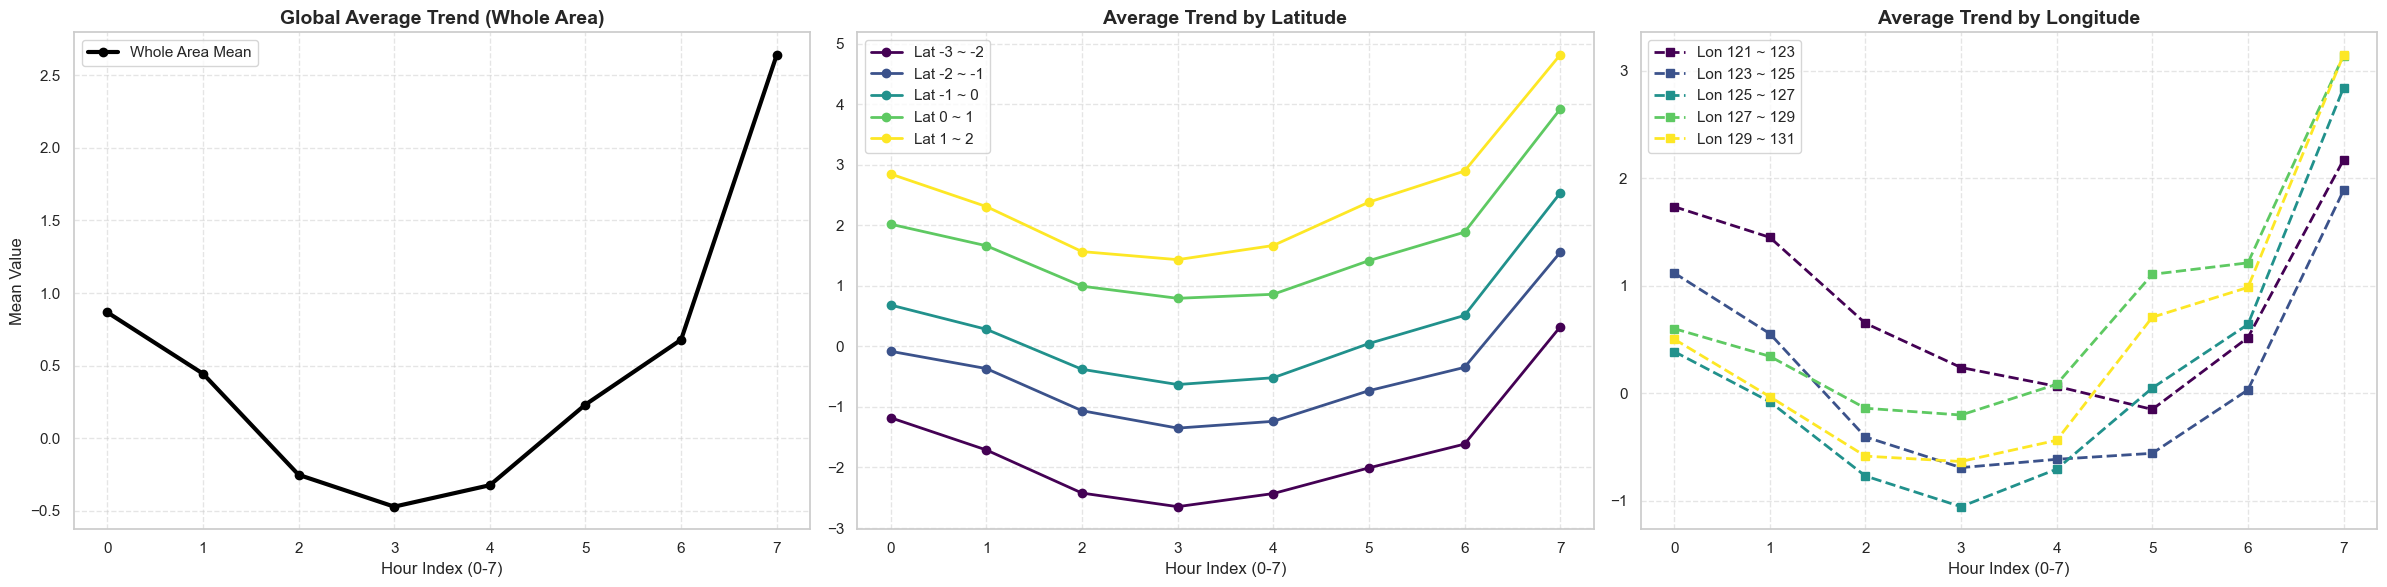

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def analyze_average_trend_28days_with_global(data_maps, days_to_average=28):
    """
    첫 28일(Day 0 ~ Day 27)의 데이터를 취합하여:
    1. 전체 영역 평균 (Global Mean)
    2. 위도 구간별 평균 (Latitude Bins)
    3. 경도 구간별 평균 (Longitude Bins)
    의 '평균적인 하루 패턴(Average Diurnal Cycle)'을 그립니다.
    """
    
    # 1. Slice 구간 정의
    lat_bins = np.array([-3, -2, -1, 0, 1, 2])
    lon_bins = np.array([121, 123, 125, 127, 129, 131])
    
    hours_x = np.arange(8) # 0~7시
    
    # 2. 데이터 저장소 생성
    # [Day(28), Slice(5), Hour(8)]
    lat_daily_storage = np.full((days_to_average, 5, 8), np.nan)
    lon_daily_storage = np.full((days_to_average, 5, 8), np.nan)
    
    # [추가됨] 전체 영역 평균 저장소: [Day(28), Hour(8)]
    global_daily_storage = np.full((days_to_average, 8), np.nan)

    print(f"--- Processing Average Trend for first {days_to_average} days ---")

    # --- [Loop] 28일 데이터 순회 ---
    for day_idx in range(days_to_average):
        if day_idx >= len(data_maps) or data_maps[day_idx] is None:
            continue
            
        day_data = data_maps[day_idx]
        
        # 키 정렬
        try:
            sorted_keys = sorted(day_data.keys(), key=lambda x: int(x) if isinstance(x, (int, str)) and str(x).isdigit() else x)
        except:
            sorted_keys = sorted(day_data.keys())
            
        for h_idx, key in enumerate(sorted_keys):
            if h_idx >= 8: break 
            
            # 텐서 추출 및 변환
            tensor = day_data[key]
            if isinstance(tensor, torch.Tensor):
                data = tensor.detach().cpu().numpy()
            else:
                data = tensor
            
            if data.size == 0:
                continue

            lats = data[:, 0]
            lons = data[:, 1]
            vals = data[:, 2]
            
            # --- [추가됨] 1. Global Spatial Mean ---
            # 해당 시간대, 전체 영역의 평균값 저장
            global_daily_storage[day_idx, h_idx] = np.mean(vals)
            
            # --- 2. Latitude Slicing ---
            lat_inds = np.digitize(lats, lat_bins) - 1
            for i in range(5):
                mask = lat_inds == i
                if np.any(mask):
                    lat_daily_storage[day_idx, i, h_idx] = np.mean(vals[mask])
            
            # --- 3. Longitude Slicing ---
            lon_inds = np.digitize(lons, lon_bins) - 1
            for i in range(5):
                mask = lon_inds == i
                if np.any(mask):
                    lon_daily_storage[day_idx, i, h_idx] = np.mean(vals[mask])

    # 3. 28일치 평균 계산 (Aggregation)
    # 28일간의 같은 시간대끼리 평균을 냄
    final_global_means = np.nanmean(global_daily_storage, axis=0) # Shape: (8,)
    final_lat_means = np.nanmean(lat_daily_storage, axis=0)       # Shape: (5, 8)
    final_lon_means = np.nanmean(lon_daily_storage, axis=0)       # Shape: (5, 8)

    # 4. 그래프 그리기 (1행 3열로 변경)
    fig, axes = plt.subplots(1, 3, figsize=(24, 6))
    
    # --- [추가됨] Plot 1: Global Average Trend ---
    ax_global = axes[0]
    ax_global.plot(hours_x, final_global_means, marker='o', linewidth=3, color='black', label='Whole Area Mean')
    
    # (선택사항) 28일간의 변동폭(표준편차)을 음영으로 표시하고 싶다면 아래 주석 해제
    # global_std = np.nanstd(global_daily_storage, axis=0)
    # ax_global.fill_between(hours_x, final_global_means - global_std, final_global_means + global_std, color='gray', alpha=0.2, label='Std Dev (28 days)')

    ax_global.set_title(f"Global Average Trend (Whole Area)", fontsize=14, fontweight='bold')
    ax_global.set_xlabel("Hour Index (0-7)", fontsize=12)
    ax_global.set_ylabel("Mean Value", fontsize=12)
    ax_global.grid(True, linestyle='--', alpha=0.5)
    ax_global.legend(fontsize='medium')

    # --- Plot 2: Latitude Trend ---
    ax_lat = axes[1]
    colors = plt.cm.viridis(np.linspace(0, 1, 5))
    
    for i in range(5):
        label = f"Lat {lat_bins[i]} ~ {lat_bins[i+1]}"
        if not np.all(np.isnan(final_lat_means[i])):
            ax_lat.plot(hours_x, final_lat_means[i], marker='o', linewidth=2, label=label, color=colors[i])

    ax_lat.set_title(f"Average Trend by Latitude", fontsize=14, fontweight='bold')
    ax_lat.set_xlabel("Hour Index (0-7)", fontsize=12)
    # ax_lat.set_ylabel("Mean Value", fontsize=12) # Y축 라벨은 첫 번째 그래프에 있으므로 생략 가능
    ax_lat.grid(True, linestyle='--', alpha=0.5)
    ax_lat.legend(fontsize='medium')

    # --- Plot 3: Longitude Trend ---
    ax_lon = axes[2]
    
    for i in range(5):
        label = f"Lon {lon_bins[i]} ~ {lon_bins[i+1]}"
        if not np.all(np.isnan(final_lon_means[i])):
            ax_lon.plot(hours_x, final_lon_means[i], marker='s', linestyle='--', linewidth=2, label=label, color=colors[i])
            
    ax_lon.set_title(f"Average Trend by Longitude", fontsize=14, fontweight='bold')
    ax_lon.set_xlabel("Hour Index (0-7)", fontsize=12)
    ax_lon.grid(True, linestyle='--', alpha=0.5)
    ax_lon.legend(fontsize='medium')

    plt.tight_layout()
    plt.show()

# 실행
analyze_average_trend_28days_with_global(daily_hourly_maps_dw, days_to_average=28)

In [ ]:
daily_hourly_maps_dw[0]['']

{'2024_07_y24m07day01_hm00:53': tensor([[  1.9987, 130.9380,   4.4069,  ...,   0.0000,   0.0000,   0.0000],
         [  1.9987, 130.9380,   4.5540,  ...,   0.0000,   0.0000,   0.0000],
         [  1.9990, 130.8762,   4.8065,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [ -2.9772, 121.1423,  -3.8739,  ...,   0.0000,   0.0000,   0.0000],
         [ -2.9772, 121.0789,  -5.3326,  ...,   0.0000,   0.0000,   0.0000],
         [ -2.9773, 121.0161,  -1.4550,  ...,   0.0000,   0.0000,   0.0000]],
        dtype=torch.float64),
 '2024_07_y24m07day01_hm01:53': tensor([[  1.9279, 130.9948,   4.9583,  ...,   0.0000,   0.0000,   0.0000],
         [  1.9279, 130.9948,   5.4391,  ...,   0.0000,   0.0000,   0.0000],
         [  1.8846, 130.9321,   4.7155,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [ -2.9821, 121.2013,  -3.4779,  ...,   0.0000,   0.0000,   0.0000],
         [ -2.9821, 121.1382,  -2.0011,  ...,   0.0000,   0.0000,   0.0000],
         [ -2.9822, 121.0754,  -

롱지튜드

--- Processing Average Trend for first 28 days ---


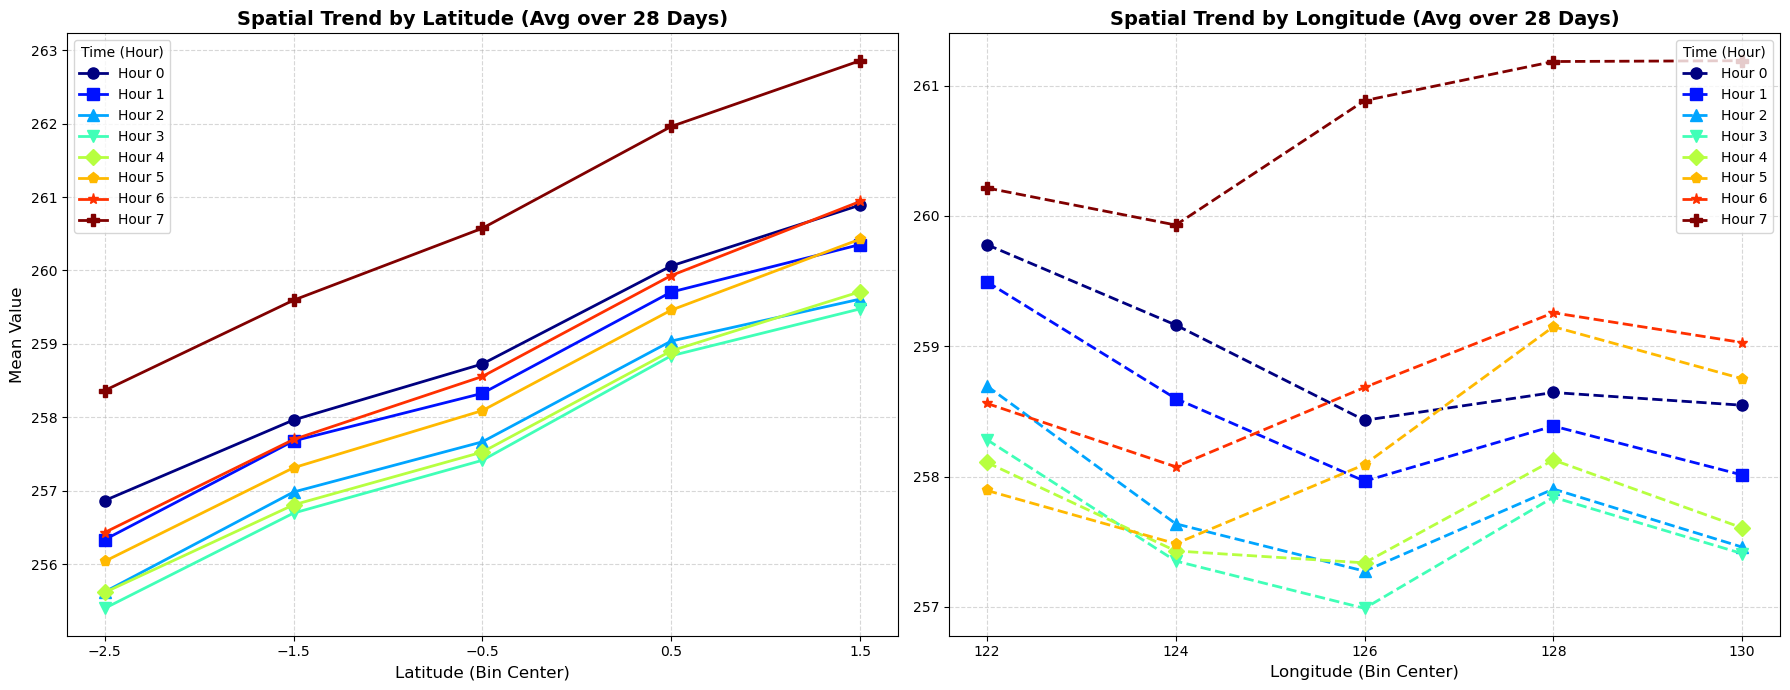

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def analyze_average_trend_28days_spatial_x(data_maps, days_to_average=28):
    """
    첫 28일(Day 0 ~ Day 27)의 데이터를 취합하여 평균을 낸 뒤,
    X축을 위도/경도로 설정하여 '시간대별(0~7시) 공간 패턴'을 그립니다.
    """
    
    # 1. Slice 구간 정의
    lat_bins = np.array([-3, -2, -1, 0, 1, 2])
    lon_bins = np.array([121, 123, 125, 127, 129, 131])
    
    # 그래프 X축에 사용할 구간의 중심값 계산 (예: -3~-2 -> -2.5)
    lat_centers = (lat_bins[:-1] + lat_bins[1:]) / 2
    lon_centers = (lon_bins[:-1] + lon_bins[1:]) / 2
    
    # 2. 데이터 저장소 생성 (3D Array) -> [Day, Slice, Hour]
    lat_daily_storage = np.full((days_to_average, 5, 8), np.nan)
    lon_daily_storage = np.full((days_to_average, 5, 8), np.nan)

    print(f"--- Processing Average Trend for first {days_to_average} days ---")

    # --- [Loop] 28일 데이터 순회 ---
    for day_idx in range(days_to_average):
        if day_idx >= len(data_maps) or data_maps[day_idx] is None:
            continue
            
        day_data = data_maps[day_idx]
        
        # 키 정렬
        try:
            sorted_keys = sorted(day_data.keys(), key=lambda x: int(x) if isinstance(x, (int, str)) and str(x).isdigit() else x)
        except:
            sorted_keys = sorted(day_data.keys())
            
        for h_idx, key in enumerate(sorted_keys):
            if h_idx >= 8: break 
            
            tensor = day_data[key]
            if isinstance(tensor, torch.Tensor):
                data = tensor.detach().cpu().numpy()
            else:
                data = tensor
            
            if data.size == 0: continue

            lats = data[:, 0]
            lons = data[:, 1]
            vals = data[:, 2]
            
            # --- Latitude Slicing ---
            lat_inds = np.digitize(lats, lat_bins) - 1
            for i in range(5):
                mask = lat_inds == i
                if np.any(mask):
                    lat_daily_storage[day_idx, i, h_idx] = np.mean(vals[mask])
            
            # --- Longitude Slicing ---
            lon_inds = np.digitize(lons, lon_bins) - 1
            for i in range(5):
                mask = lon_inds == i
                if np.any(mask):
                    lon_daily_storage[day_idx, i, h_idx] = np.mean(vals[mask])

    # 3. 28일치 평균 계산 (Aggregation)
    # 결과 shape: (Slice=5, Hour=8)
    final_lat_means = np.nanmean(lat_daily_storage, axis=0)
    final_lon_means = np.nanmean(lon_daily_storage, axis=0)

    # 4. 그래프 그리기 (1행 2열)
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    
    # 시간대별(0~7) 마커와 색상 정의
    # 마커 종류: 원, 네모, 세모, 역세모, 다이아몬드, 육각형, 별, 플러스
    markers = ['o', 's', '^', 'v', 'D', 'p', '*', 'P'] 
    # 색상맵 (시간 흐름에 따라 그라데이션)
    colors = plt.cm.jet(np.linspace(0, 1, 8)) 

    # --- Latitude Plot (X축: Latitude) ---
    ax_lat = axes[0]
    for h in range(8): # 시간(Hour) 루프
        # 해당 시간의 모든 위도 구간 값 추출
        y_values = final_lat_means[:, h]
        
        # NaN이 아닌 경우만 플롯
        if not np.all(np.isnan(y_values)):
            ax_lat.plot(lat_centers, y_values, 
                        marker=markers[h], markersize=8, 
                        color=colors[h], linewidth=2, 
                        label=f'Hour {h}')
            
    ax_lat.set_title(f"Spatial Trend by Latitude (Avg over {days_to_average} Days)", fontsize=14, fontweight='bold')
    ax_lat.set_xlabel("Latitude (Bin Center)", fontsize=12)
    ax_lat.set_ylabel("Mean Value", fontsize=12)
    ax_lat.set_xticks(lat_centers) # X축 눈금을 구간 중심으로 고정
    ax_lat.grid(True, linestyle='--', alpha=0.5)
    ax_lat.legend(title="Time (Hour)", fontsize='medium')

    # --- Longitude Plot (X축: Longitude) ---
    ax_lon = axes[1]
    for h in range(8): # 시간(Hour) 루프
        # 해당 시간의 모든 경도 구간 값 추출
        y_values = final_lon_means[:, h]
        
        if not np.all(np.isnan(y_values)):
            ax_lon.plot(lon_centers, y_values, 
                        marker=markers[h], markersize=8, 
                        color=colors[h], linewidth=2, linestyle='--',
                        label=f'Hour {h}')
            
    ax_lon.set_title(f"Spatial Trend by Longitude (Avg over {days_to_average} Days)", fontsize=14, fontweight='bold')
    ax_lon.set_xlabel("Longitude (Bin Center)", fontsize=12)
    ax_lon.set_xticks(lon_centers) # X축 눈금을 구간 중심으로 고정
    ax_lon.grid(True, linestyle='--', alpha=0.5)
    ax_lon.legend(title="Time (Hour)", fontsize='medium')

    plt.tight_layout()
    plt.show()

# 실행
analyze_average_trend_28days_spatial_x(daily_hourly_maps_dw, days_to_average=28)

--- Aggregating data for 28 days ---


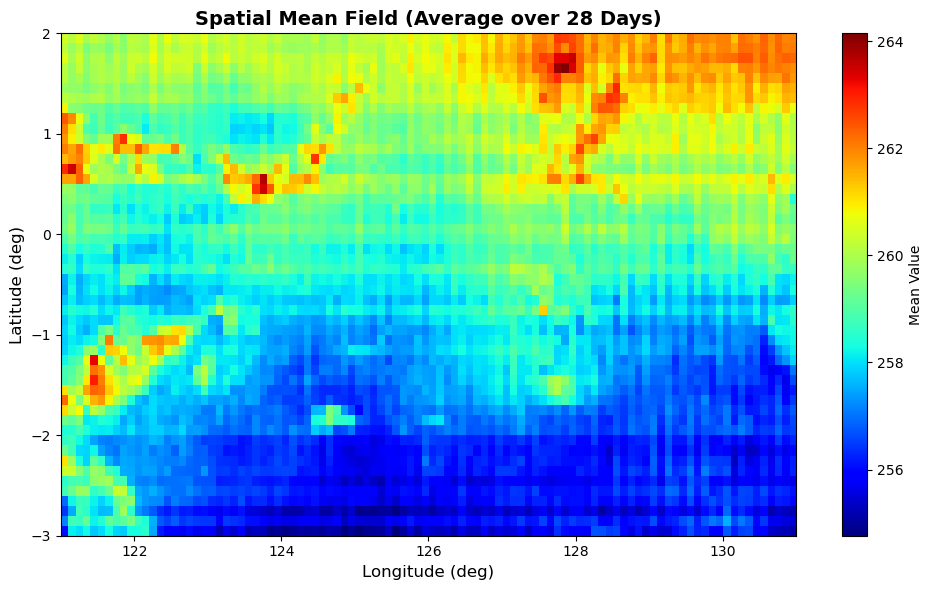

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.stats import binned_statistic_2d

def plot_spatial_mean_field(data_maps, days_to_average=28, grid_size=0.1):
    """
    28일치 데이터를 모두 모아 (위도, 경도) 격자별로 평균을 낸 Heatmap을 그립니다.
    표준적인 지도 형태(X=Lon, Y=Lat)로 시각화합니다.
    """
    print(f"--- Aggregating data for {days_to_average} days ---")
    
    all_lats = []
    all_lons = []
    all_vals = []

    # 1. 28일치 데이터 수집 (모든 점을 리스트에 담기)
    for day_idx in range(days_to_average):
        if day_idx >= len(data_maps) or data_maps[day_idx] is None:
            continue
            
        day_data = data_maps[day_idx]
        for key in day_data.keys():
            tensor = day_data[key]
            if isinstance(tensor, torch.Tensor):
                data = tensor.detach().cpu().numpy()
            else:
                data = tensor
            
            if data.size == 0: continue
            
            # 데이터 누적
            all_lats.append(data[:, 0])
            all_lons.append(data[:, 1])
            all_vals.append(data[:, 2])

    # 리스트를 하나의 거대한 Numpy 배열로 병합
    if not all_vals:
        print("No data found.")
        return

    all_lats = np.concatenate(all_lats)
    all_lons = np.concatenate(all_lons)
    all_vals = np.concatenate(all_vals)

    # 2. 격자(Grid) 생성 및 평균 계산 (Binning)
    # 범위 설정
    lat_min, lat_max = -3, 2
    lon_min, lon_max = 121, 131
    
    # 격자 개수 계산
    lat_bins = np.arange(lat_min, lat_max + grid_size, grid_size)
    lon_bins = np.arange(lon_min, lon_max + grid_size, grid_size)
    
    # scipy를 이용해 2D Binning (격자 내 평균 계산)
    # 통상적인 지도(Map) 형태를 위해 x=lon, y=lat 순서로 넣습니다.
    # 만약 교수님 말씀대로 X=Lat, Y=Lon을 원하면 순서를 바꾸면 됩니다.
    ret = binned_statistic_2d(
        x=all_lons, 
        y=all_lats, 
        values=all_vals, 
        statistic='mean', 
        bins=[lon_bins, lat_bins]
    )
    
    heatmap_data = ret.statistic.T # Transpose to match (Y=Lat, X=Lon) convention for imshow

    # 3. 그리기
    plt.figure(figsize=(10, 6))
    
    # Heatmap 그리기
    # origin='lower': 아래쪽이 낮은 위도
    plt.imshow(heatmap_data, origin='lower', cmap='jet', aspect='auto',
               extent=[lon_min, lon_max, lat_min, lat_max])
    
    plt.colorbar(label='Mean Value')
    plt.title(f"Spatial Mean Field (Average over {days_to_average} Days)", fontsize=14, fontweight='bold')
    plt.xlabel("Longitude (deg)", fontsize=12)
    plt.ylabel("Latitude (deg)", fontsize=12)
    plt.grid(False) # Heatmap이라 그리드는 뺌 (필요하면 True)

    plt.tight_layout()
    plt.show()

# 실행
# grid_size=0.1은 약 10km 해상도입니다. 데이터 밀도에 따라 0.2나 0.5로 조절하세요.
plot_spatial_mean_field(daily_hourly_maps_dw, days_to_average=28, grid_size=0.1)

--- Aggregating Hourly Data for 28 days ---
Global Color Scale: 236.01 ~ 250.89


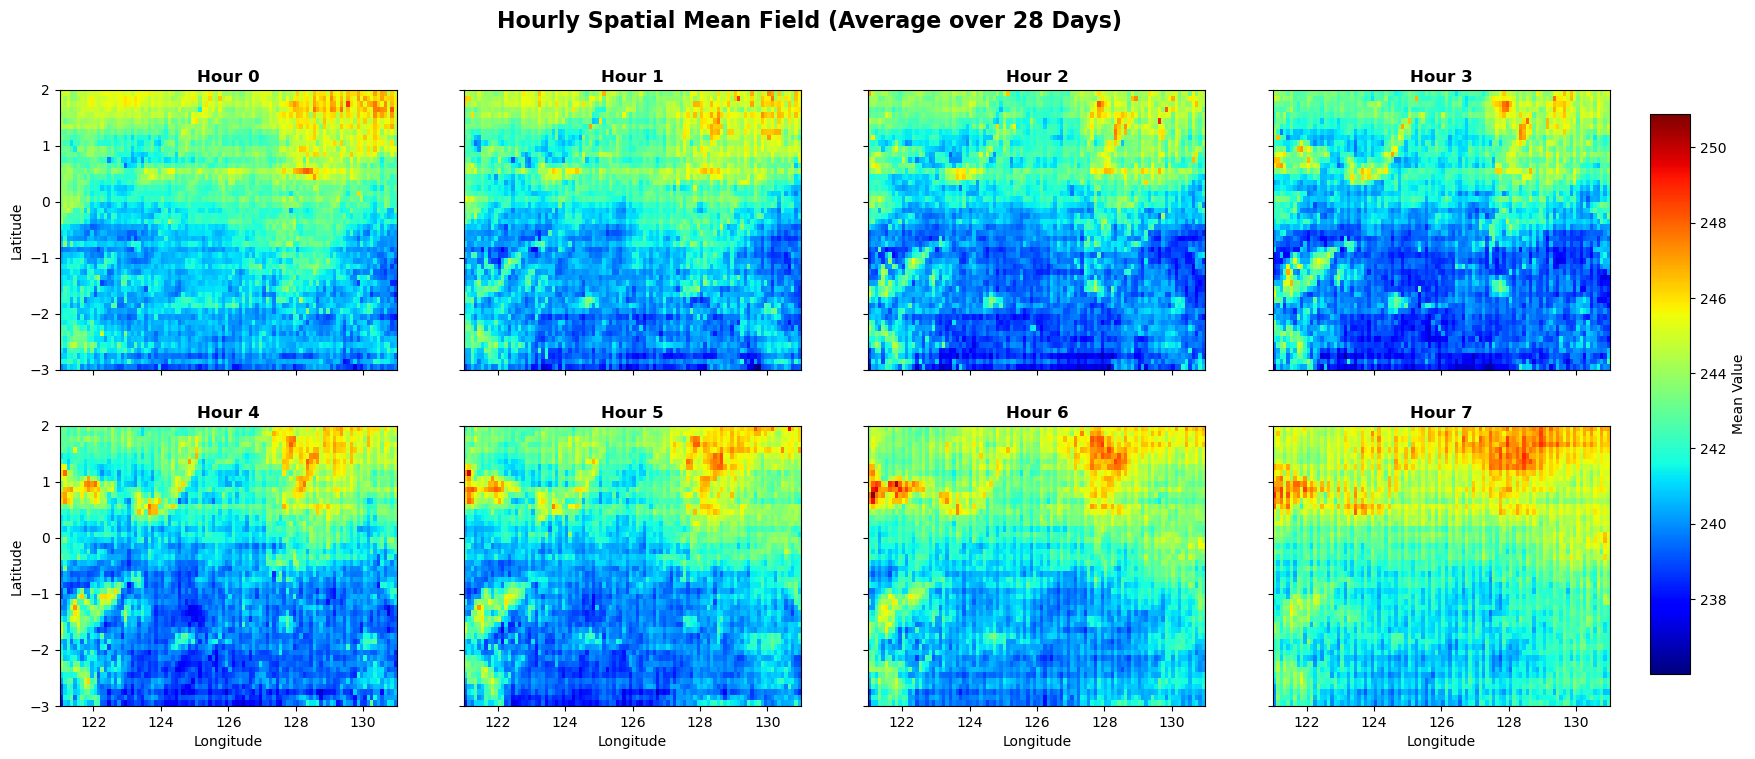

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.stats import binned_statistic_2d

def plot_hourly_spatial_means(data_maps, days_to_average=28, grid_size=0.1):
    """
    28일치 데이터를 '시간대(Hour 0~7)'별로 모아서 공간 평균을 냅니다.
    2x4 Subplot으로 시각화하여 하루 동안의 변화 패턴(Diurnal Cycle)을 봅니다.
    """
    print(f"--- Aggregating Hourly Data for {days_to_average} days ---")
    
    # 1. 시간대별 데이터 저장소 (0~7시)
    # hourly_data[hour_idx] = {'lats': [], 'lons': [], 'vals': []}
    hourly_data = {h: {'lats': [], 'lons': [], 'vals': []} for h in range(8)}
    
    # 2. 데이터 수집
    for day_idx in range(days_to_average):
        if day_idx >= len(data_maps) or data_maps[day_idx] is None: continue
            
        day_data = data_maps[day_idx]
        
        # 키 정렬 (0, 1, ... 7)
        try:
            sorted_keys = sorted(day_data.keys(), key=lambda x: int(x) if str(x).isdigit() else x)
        except:
            sorted_keys = sorted(day_data.keys())
            
        for h_idx, key in enumerate(sorted_keys):
            if h_idx >= 8: break
            
            tensor = day_data[key]
            if isinstance(tensor, torch.Tensor):
                data = tensor.detach().cpu().numpy()
            else:
                data = tensor
            
            if data.size == 0: continue
            
            hourly_data[h_idx]['lats'].append(data[:, 0])
            hourly_data[h_idx]['lons'].append(data[:, 1])
            hourly_data[h_idx]['vals'].append(data[:, 2])

    # 3. 데이터 병합 및 격자화 (Gridding)
    # 모든 시간대의 데이터를 미리 계산해서 Global Min/Max를 찾습니다 (Colorbar 통일용)
    heatmaps = []
    
    # 범위 설정
    lat_min, lat_max = -3, 2
    lon_min, lon_max = 121, 131
    lat_bins = np.arange(lat_min, lat_max + grid_size, grid_size)
    lon_bins = np.arange(lon_min, lon_max + grid_size, grid_size)
    
    for h in range(8):
        if not hourly_data[h]['vals']:
            heatmaps.append(None)
            continue
            
        lats = np.concatenate(hourly_data[h]['lats'])
        lons = np.concatenate(hourly_data[h]['lons'])
        vals = np.concatenate(hourly_data[h]['vals'])
        
        ret = binned_statistic_2d(
            x=lons, y=lats, values=vals, 
            statistic='mean', bins=[lon_bins, lat_bins]
        )
        # Transpose for imshow (Y=Lat, X=Lon)
        heatmaps.append(ret.statistic.T)

    # 4. Global Min/Max 찾기 (Color Scale 통일)
    valid_maps = [m for m in heatmaps if m is not None]
    if not valid_maps:
        print("No data available.")
        return
        
    vmin = np.nanmin([np.nanmin(m) for m in valid_maps])
    vmax = np.nanmax([np.nanmax(m) for m in valid_maps])
    
    print(f"Global Color Scale: {vmin:.2f} ~ {vmax:.2f}")

    # 5. Plotting (2x4 Grid)
    fig, axes = plt.subplots(2, 4, figsize=(20, 8), sharex=True, sharey=True)
    axes = axes.flatten()
    
    for h in range(8):
        ax = axes[h]
        if heatmaps[h] is None:
            ax.text(0.5, 0.5, "No Data", ha='center', transform=ax.transAxes)
            continue
            
        im = ax.imshow(heatmaps[h], origin='lower', cmap='jet', aspect='auto',
                       extent=[lon_min, lon_max, lat_min, lat_max],
                       vmin=vmin, vmax=vmax) # [중요] 스케일 고정
        
        ax.set_title(f"Hour {h}", fontweight='bold')
        ax.grid(False)
        
        # 첫 번째 열에만 Y축 라벨, 마지막 행에만 X축 라벨
        if h % 4 == 0: ax.set_ylabel("Latitude")
        if h >= 4: ax.set_xlabel("Longitude")

    # 공통 Colorbar 추가
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7]) # [left, bottom, width, height]
    fig.colorbar(im, cax=cbar_ax, label='Mean Value')
    
    fig.suptitle(f"Hourly Spatial Mean Field (Average over {days_to_average} Days)", fontsize=16, fontweight='bold')
    # plt.tight_layout(rect=[0, 0, 0.9, 1]) # Colorbar 공간 확보
    plt.show()

# 실행
plot_hourly_spatial_means(daily_hourly_maps_dw, days_to_average=28, grid_size=0.1)
